In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import plotly.offline as py

In [2]:
from sqlalchemy import create_engine
engine = create_engine('mysql+pymysql://root:@localhost:3306/customerchurn')
df = pd.read_sql('SELECT * FROM customer', con=engine)
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [3]:
df.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

In [4]:
print('Rows:',df.shape[0])
print('Columns:',df.shape[1])
print(f'\nFeatures:\n{df.columns.tolist()}\n')
print('Null Values:',df.isnull().values.sum(),'\n')
print('Distribution Data: Imbalanced Data\nNot-Churn:',round(df[df['Churn']=='No'].count()[0] / (df[df['Churn']=='No'].count()[0] + df[df['Churn']=='Yes'].count()[0])*100,2))
print('Churn:',round(df[df['Churn']=='Yes'].count()[0] / (df[df['Churn']=='No'].count()[0] + df[df['Churn']=='Yes'].count()[0])*100,2),'\n')
print(df.info())
print('\nIndicators for the columns:\n1: Yes\n0: No')

Rows: 7043
Columns: 21

Features:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Null Values: 0 

Distribution Data: Imbalanced Data
Not-Churn: 73.46
Churn: 26.54 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043

# DATA MANIPULATION

- Replacing null values to 0
- Cleaning nominal data to Yes or No

In [5]:
# Missing value in TotalCharges == 11 rows
# df[df['TotalCharges'] == ' ']

# Replacing empty values with np.NaN and convert to float
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0).astype(float)

# Replace No Internet Service to No, thus it only has 2 group (yes or no) 
# the Columns are OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
for i in df.columns[9:15]:
    df[i] = df[i].replace('No internet service','No')

# Replace No Phone Service to No, thus it only has 2 group (yes or no)
# df[(df['PhoneService'] == 'Yes') & (df['MultipleLines'] == 'No phone service')] ==> null
df['MultipleLines'] = df['MultipleLines'].replace('No phone service','No')

# Replace Senior Citizen (1,0) to (Yes or No)
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1:'Yes',0:'No'})

In [6]:
# Separating Churn and Non Churn data
churn = df[df['Churn'] == 'Yes']
nonchurn = df[df['Churn'] == 'No']

# Separating Nominal Column and Numerical column
y_col = 'Churn'
cat_cols = df.nunique()[df.nunique()<=4].keys().tolist()
cat_cols = [x for x in cat_cols if x not in y_col]
num_cols = [x for x in df.columns if x not in [y_col] + ['customerID'] + cat_cols]

# Exploratory Data Analysis of Nominal Data

<ipython-input-7-4d73dd0cbd66>:10: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



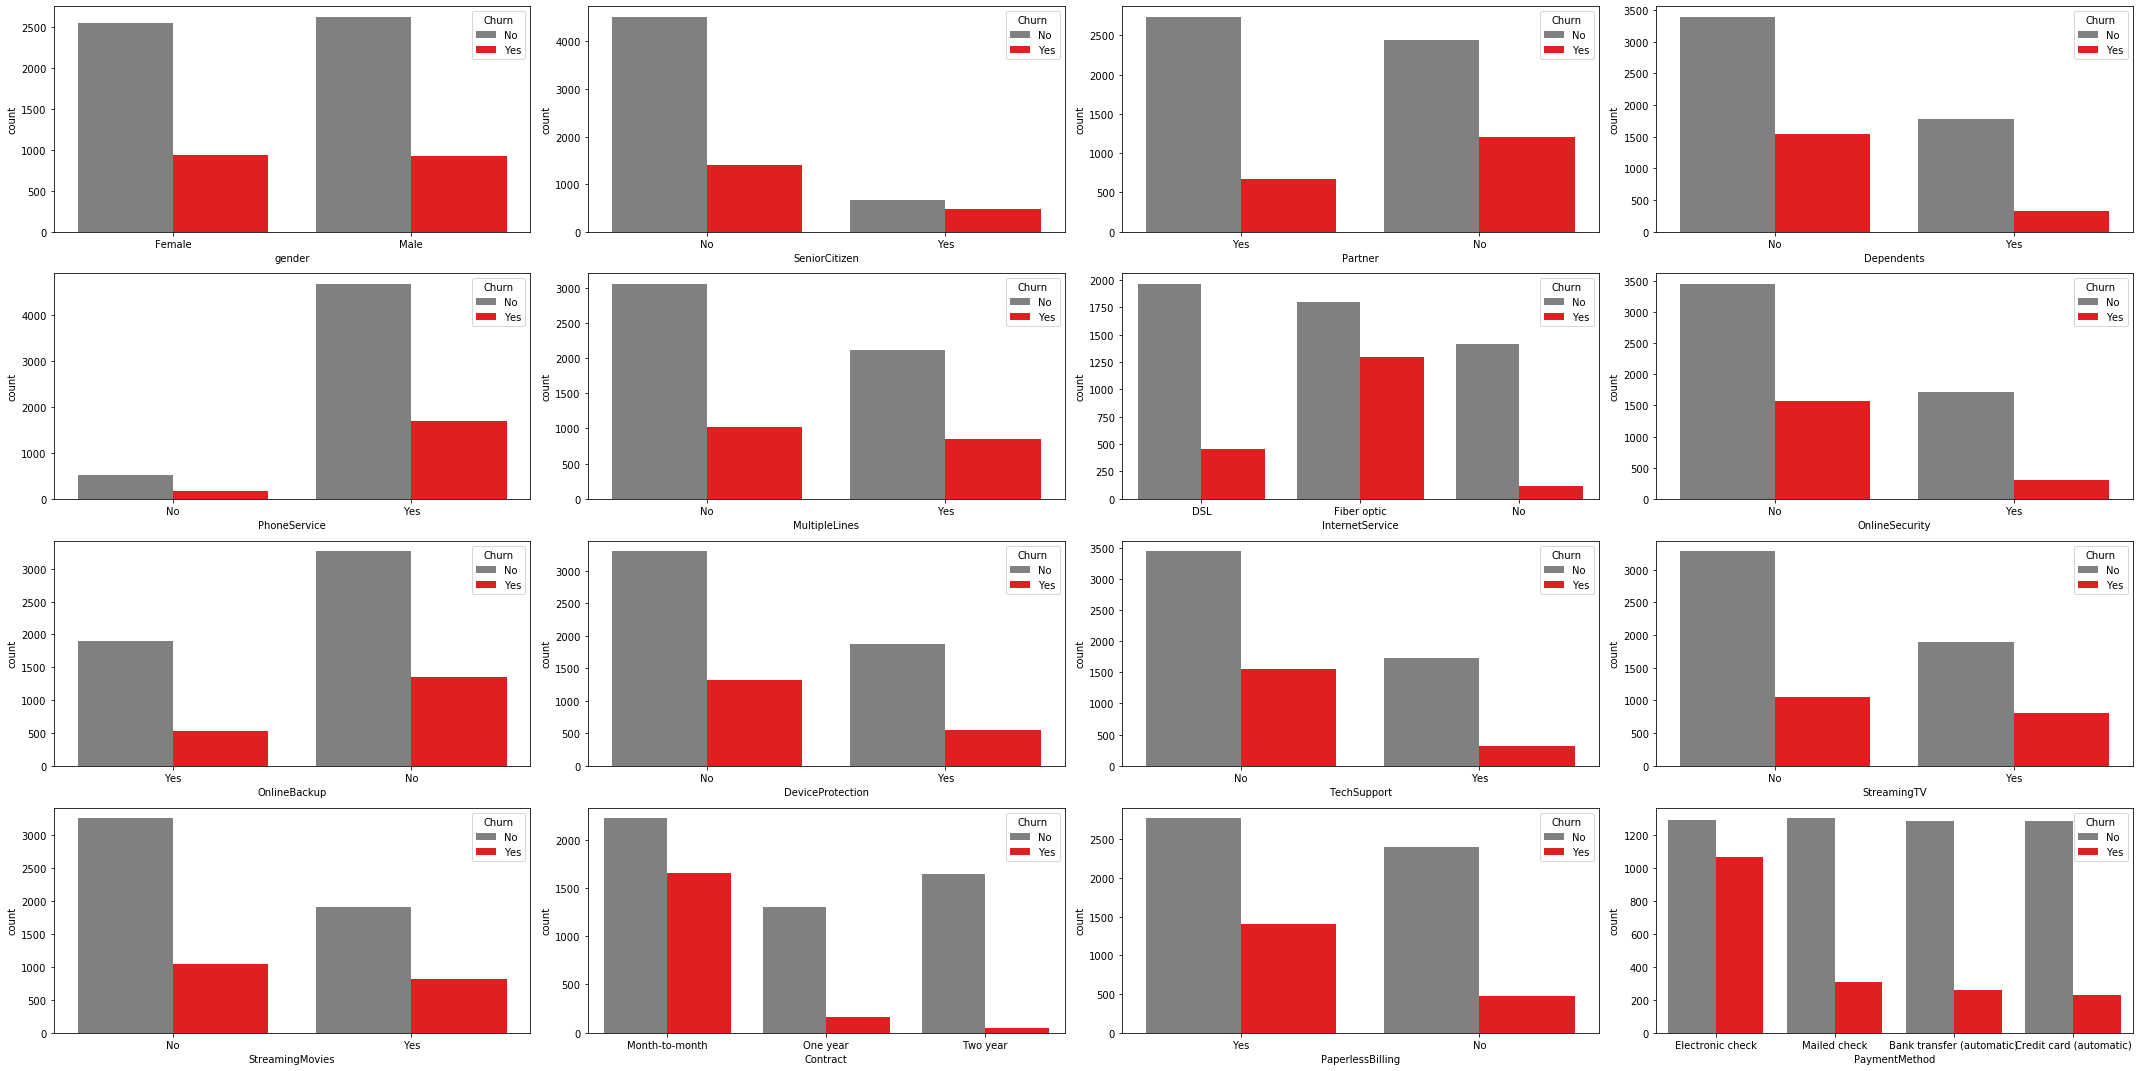

In [7]:
def bar(df):
    palette={'No':'grey','Yes':'red'}
    fig, ax = plt.subplots(4,4,figsize=(30,15))
    idx = [j for i in ax for j in i]
    num = 0
    for i in cat_cols:
        sns.countplot(x=i,data=df,hue='Churn',ax=idx[num],palette=palette)
        num+=1
    fig.tight_layout()
    return fig.show()
bar(df)
plt.savefig('BarCustomerChurn.png')

### Three Factors of Outliers: 

- data entry or measurement errors, 
- sampling problems and unusual conditions, and 
- natural variation.

                Quartile .75  Quartile .25      IQR
tenure                 55.00          9.00    46.00
MonthlyCharges         89.85         35.50    54.35
TotalCharges         3786.60        398.55  3388.05


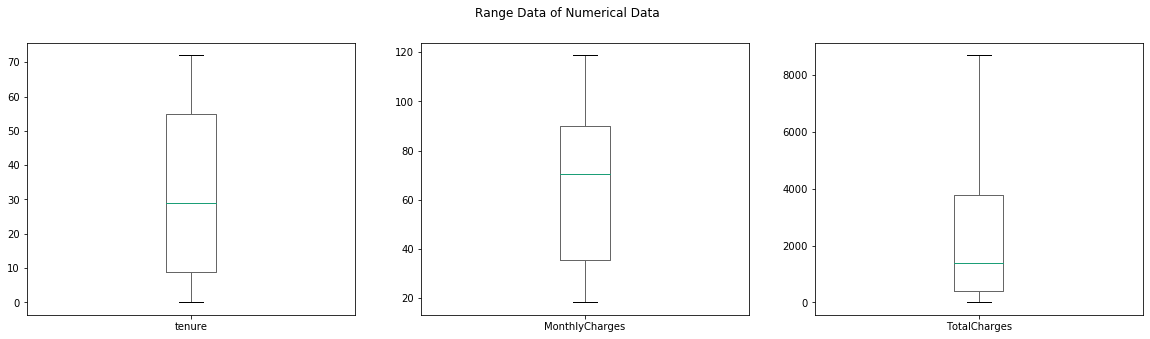

In [8]:
# Check Outliers value in each Numerical Data == null outliers
def AllBox(df):
    df.plot(kind='box',subplots=(132),figsize=(20,5),colormap='Dark2_r',title='Range Data of Numerical Data')
    q3 = df.quantile(.75)
    q1 = df.quantile(.25)
    iqr = q3-q1
    box = pd.DataFrame(index=iqr.index,columns=['Quartile .75','Quartile .25','IQR'])
    box['Quartile .75'] = q3
    box['Quartile .25'] = q1
    box['IQR'] = iqr
    print(box)
    return plt.show()
AllBox(df)

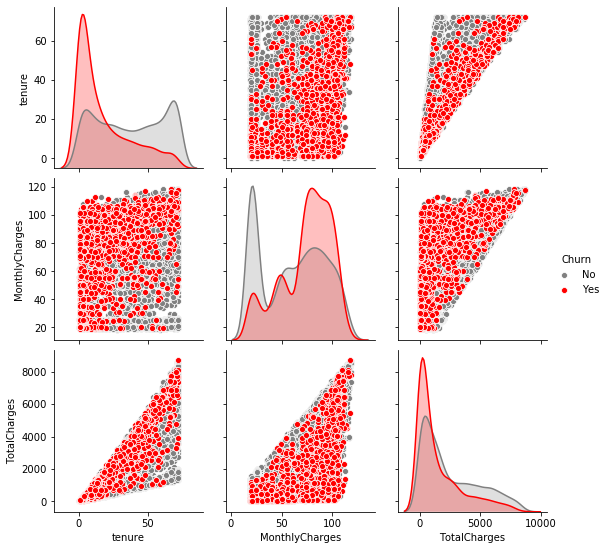

In [9]:
# Distribution of Numerical Data
palette={'No':'grey','Yes':'red'}
sns.pairplot(df,hue='Churn', kind='scatter', palette=palette)
plt.savefig('ScatterCustomerChurn.png')

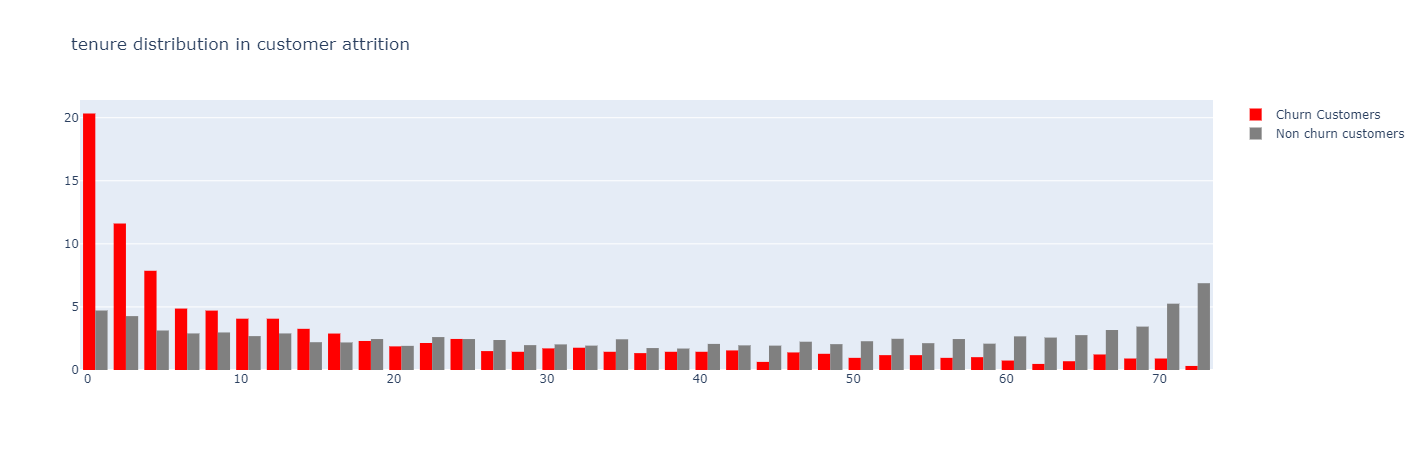

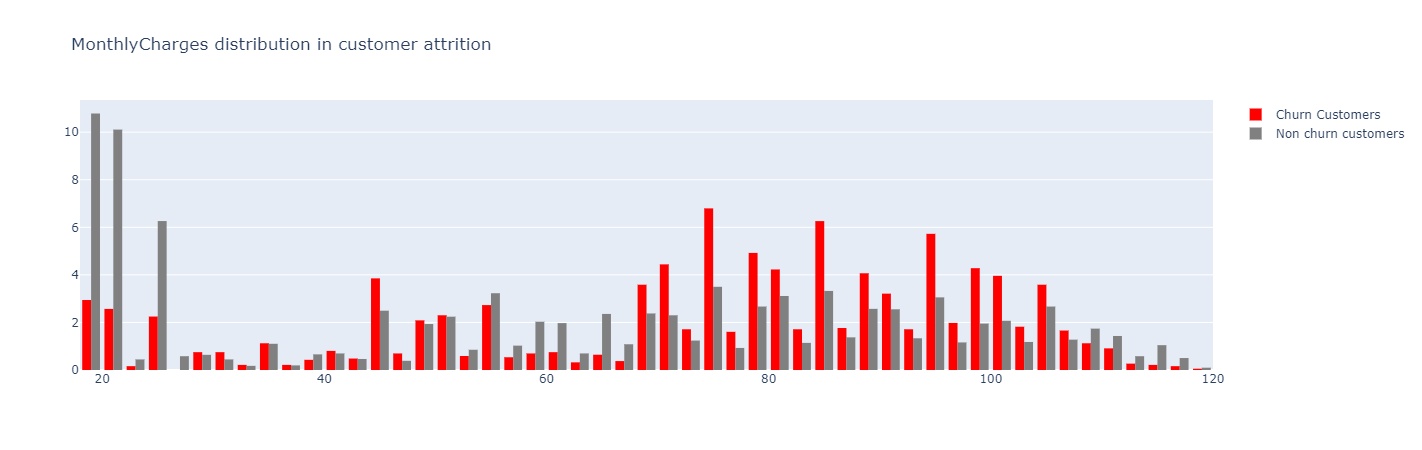

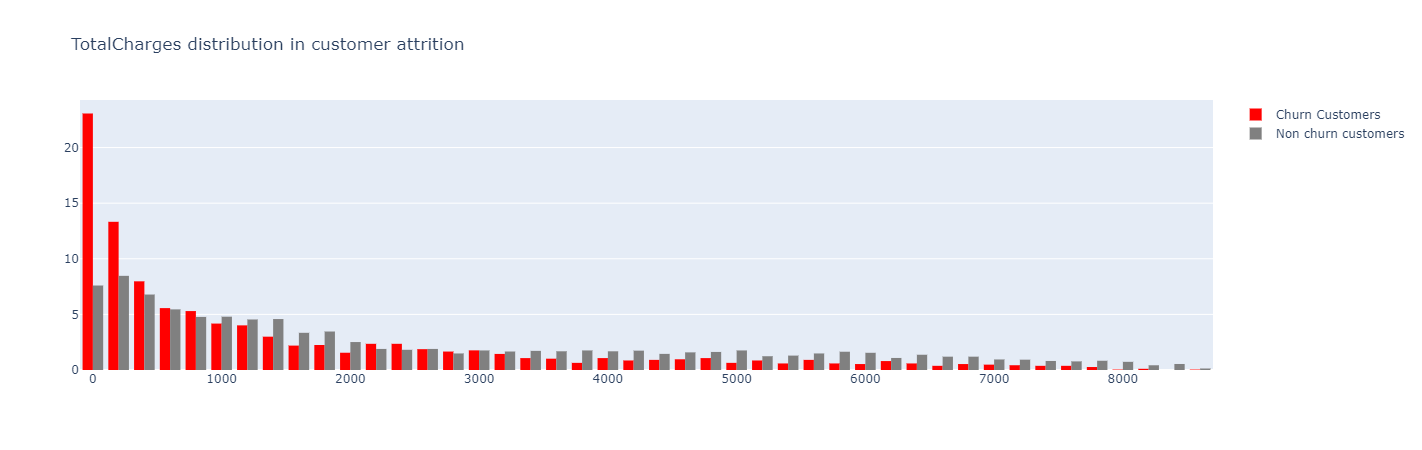

In [10]:
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(color='red')
                         )
    trace2 = go.Histogram(x  = nonchurn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(color='grey')
                         )
    data = [trace1,trace2]
    layout = go.Layout(title = column + " distribution in customer attrition ")
    fig  = go.Figure(data=data,layout=layout)
    py.iplot(fig)
    
for i in num_cols :
    histogram(i)

## Correlation of Categorical Columns

In [11]:
dfx = df.copy()
dfx = dfx[cat_cols+[y_col]]
dfx.head()

gender SeniorCitizen Partner Dependents PhoneService MultipleLines  \
0  Female            No     Yes         No           No            No   
1    Male            No      No         No          Yes            No   
2    Male            No      No         No          Yes            No   
3    Male            No      No         No           No            No   
4  Female            No      No         No          Yes            No   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0             DSL             No          Yes               No          No   
1             DSL            Yes           No              Yes          No   
2             DSL            Yes          Yes               No          No   
3             DSL            Yes           No              Yes         Yes   
4     Fiber optic             No           No               No          No   

  StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No              No  Month-to-month              Yes   
1          No              No        One year               No   
2          No              No  Month-to-month              Yes   
3          No              No        One year               No   
4          No              No  Month-to-month              Yes   

               PaymentMethod Churn  
0           Electronic check    No  
1               Mailed check    No  
2               Mailed check   Yes  
3  Bank transfer (automatic)    No  
4           Electronic check   Yes

In [22]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in dfx.columns :
    data_encoded[i]=le.fit_transform(dfx[i])
data_encoded.head()

gender  SeniorCitizen  Partner  Dependents  PhoneService  MultipleLines  \
0       0              0        1           0             0              0   
1       1              0        0           0             1              0   
2       1              0        0           0             1              0   
3       1              0        0           0             0              0   
4       0              0        0           0             1              0   

   InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
0                0               0             1                 0   
1                0               1             0                 1   
2                0               1             1                 0   
3                0               1             0                 1   
4                1               0             0                 0   

   TechSupport  StreamingTV  StreamingMovies  Contract  PaperlessBilling  \
0            0            0                0         0                 1   
1            0            0                0         1                 0   
2            0            0                0         0                 1   
3            1            0                0         1                 0   
4            0            0                0         0                 1   

   PaymentMethod  Churn  
0              2      0  
1              3      0  
2              3      1  
3              0      0  
4              2      1

In [20]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))
pd.crosstab(data_encoded['gender'],data_encoded['Churn'])

Churn      0    1
gender           
0       2549  939
1       2625  930

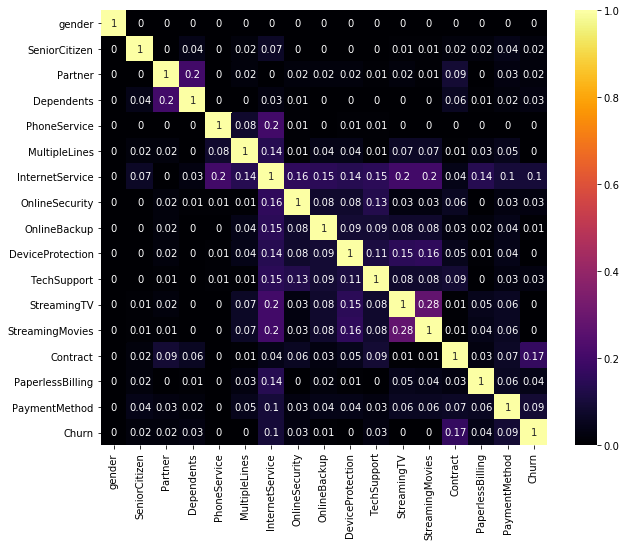

In [14]:
rows= []
for var1 in data_encoded:
    col = []
    for var2 in data_encoded :
        cramers = cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)

cramers_results = np.array(rows)
df_corr = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_corr,annot=True,ax=ax,cmap='inferno')

## Corellation of Numerical Columns

__Pearson Correlation Coefficient $r$__
    
$$\displaystyle r = \frac {n(\sum{xy}) - (\sum{x})(\sum{y})}
{\sqrt{ (n \sum{x^2} - (\sum{x}^2)) (n \sum{y^2} - (\sum{y})^2) }} $$

<ipython-input-15-4ff3846645de>:3: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



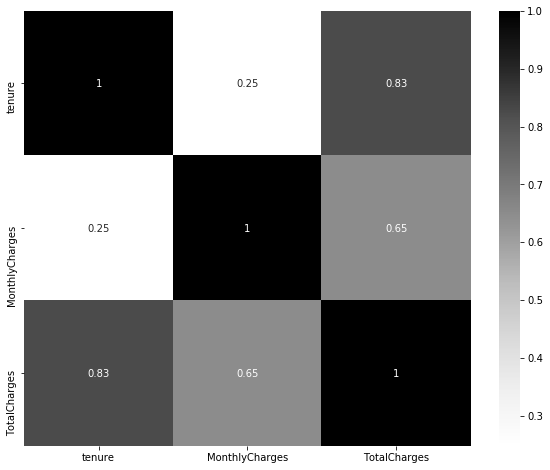

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df[num_cols].corr(),annot=True,ax=ax,cmap='Greys')
fig.show()

In [16]:
import joblib

In [17]:
# Save as binary (no extension / ext = .joblib)

joblib.dump(df, 'DFjoblib')

['DFjoblib']

In [18]:
# # Create Customer ID
# import random
# import string

# def randomString(stringLength=10):
#     digit = string.digits
#     letters = string.ascii_uppercase
#     depan = ''.join(random.choice(digit) for i in range(4))
#     belakang = ''.join(random.choice(letters) for i in range(5))
#     return f'{depan}-{belakang}'

# print("Random String is ", randomString())
# print("Random String is ", randomString(5))
# print("Random String is ", randomString(5))